In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Set Pandas display options for easier viewing
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [2]:
# Function to read and reduce memory usage for large datasets
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Reading and preprocessing data
sell_prices_df = reduce_mem_usage(pd.read_csv('sell_prices.csv'))
calendar_df = reduce_mem_usage(pd.read_csv('calendar.csv'))
sales_train_evaluation_df = reduce_mem_usage(pd.read_csv('sales_train_evaluation.csv'))


Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [5]:
#Data Exploring
# Shape of the datasets
print('calendar Shape:', calendar_df.shape,)
print('train Shape:', sales_train_evaluation_df.shape)
print('prices Shape:', sell_prices_df.shape)

calendar Shape: (1969, 14)
train Shape: (30490, 1947)
prices Shape: (6841121, 4)


In [4]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1941]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [5]:
# Concatenat item ID and Store Id,and use them as columns names 
sales_train_evaluation_df['item_store_id'] = sales_train_evaluation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_evaluation_df.loc[:,'d_1':'d_1941'].T
DF_Sales.columns = sales_train_evaluation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


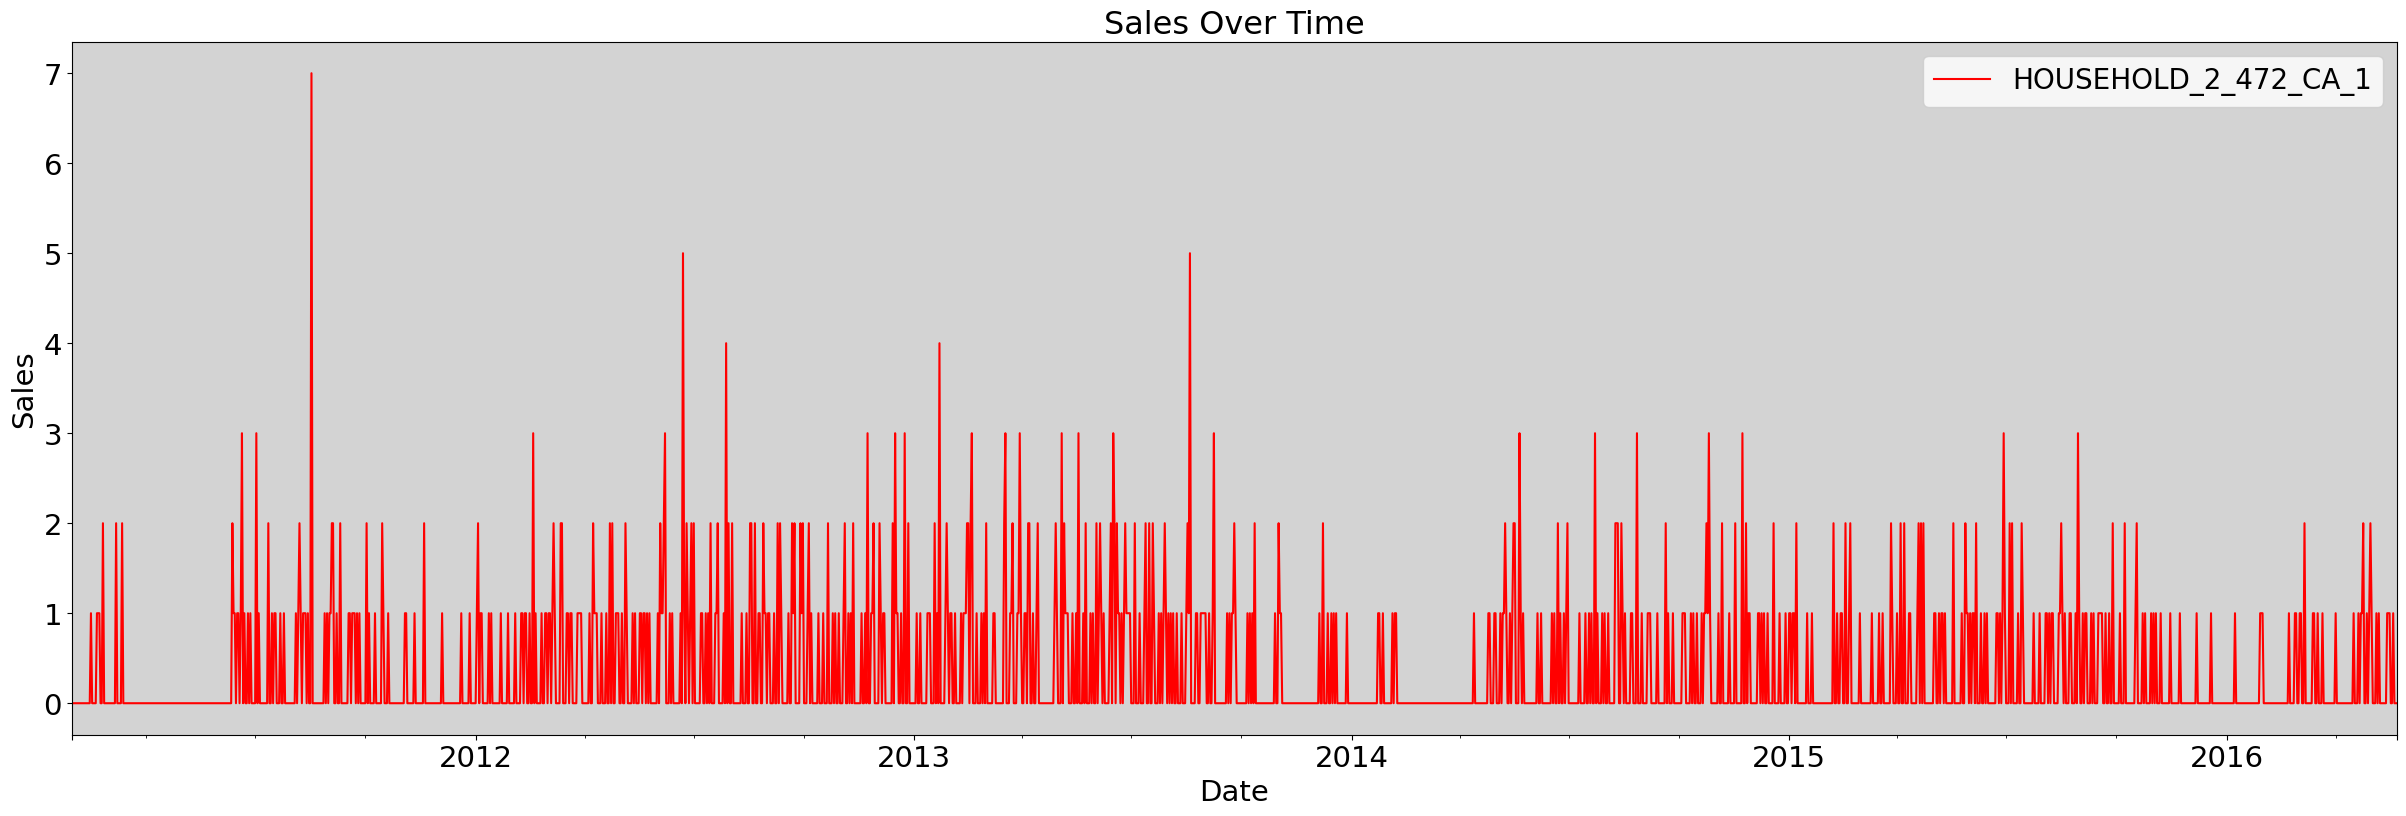

In [6]:
#Select a random index and plot the time series
index = 1567
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

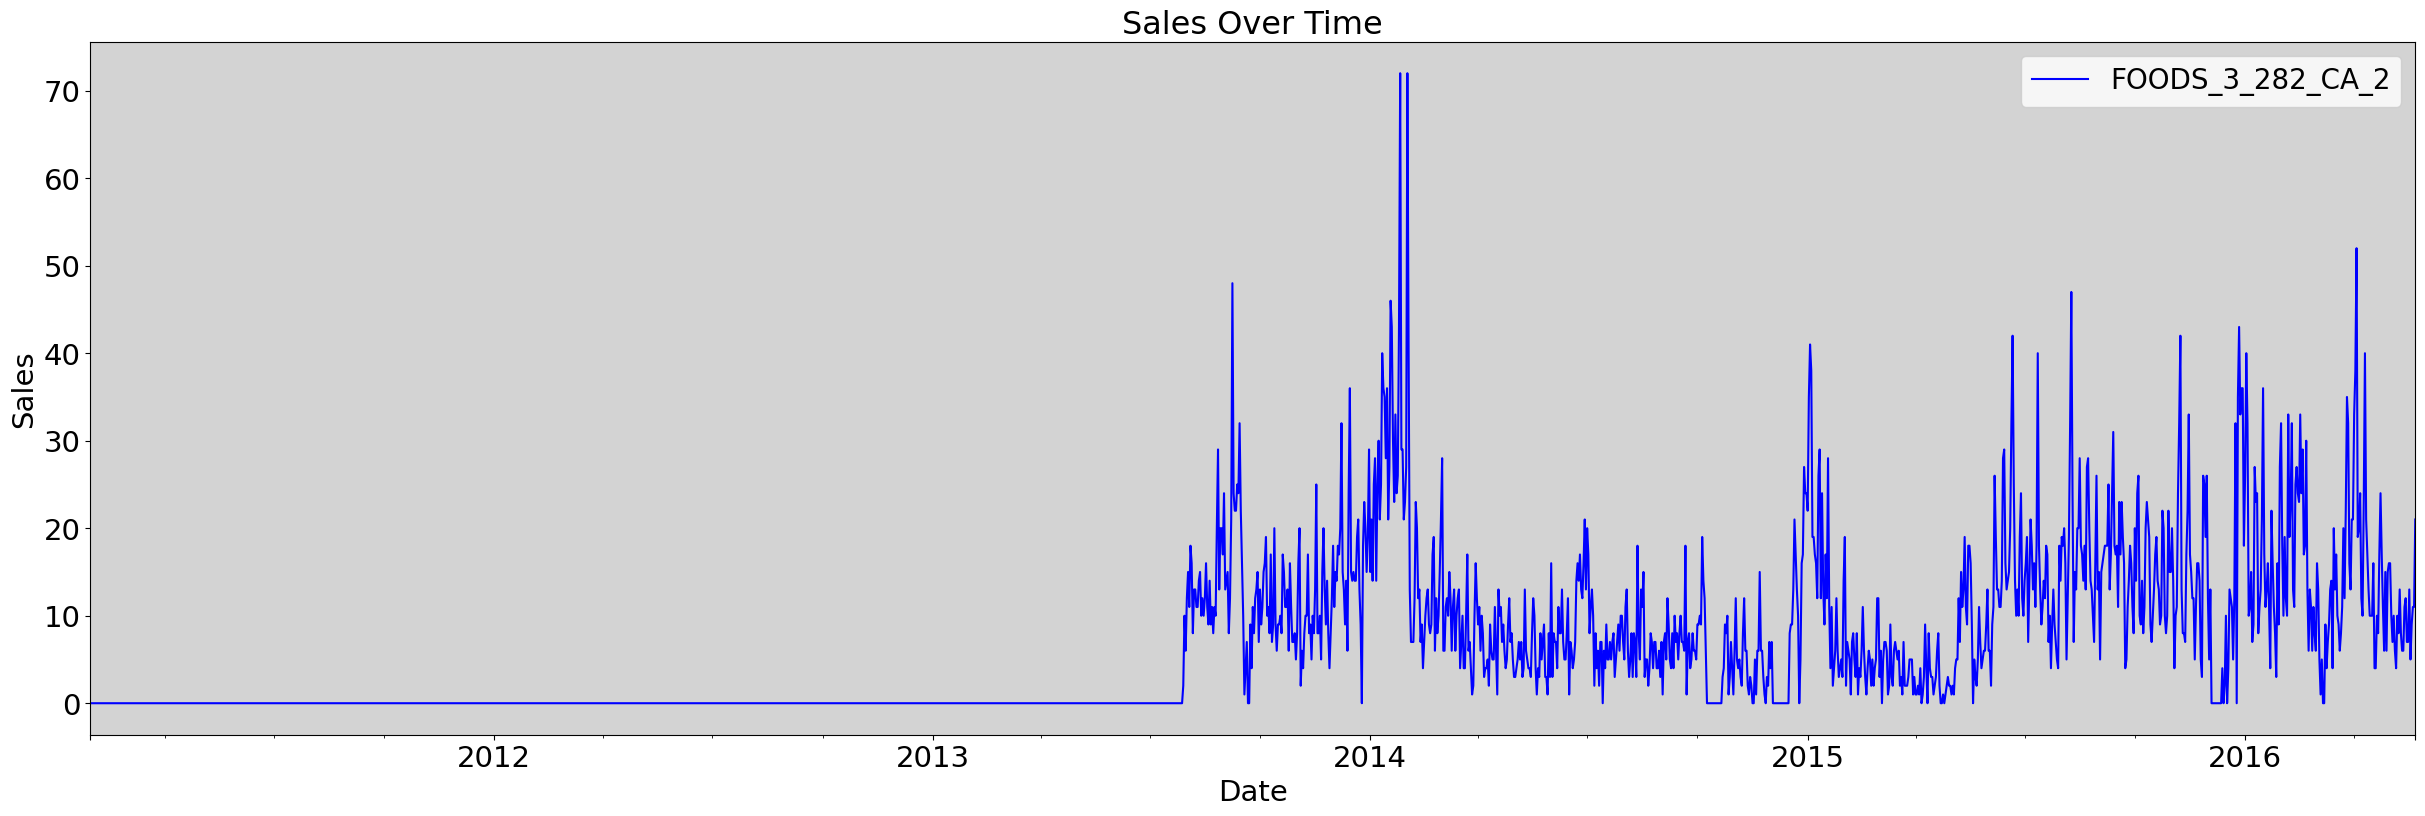

In [7]:
index = 5555
y1 = pd.DataFrame(DF_Sales.iloc[:,index])
y1 = pd.DataFrame(y1).set_index([dates_list])
TS_selected = y1 
y1.index = pd.to_datetime(y1.index)
ax = y1.plot(figsize=(30, 9),color='blue')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 54321
seed_everything(SEED)

In [9]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [10]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.        ]
 [0.14285714]
 [0.        ]
 [0.        ]
 [0.        ]]


<Axes: title={'center': ' After Normalization'}, ylabel='Frequency'>

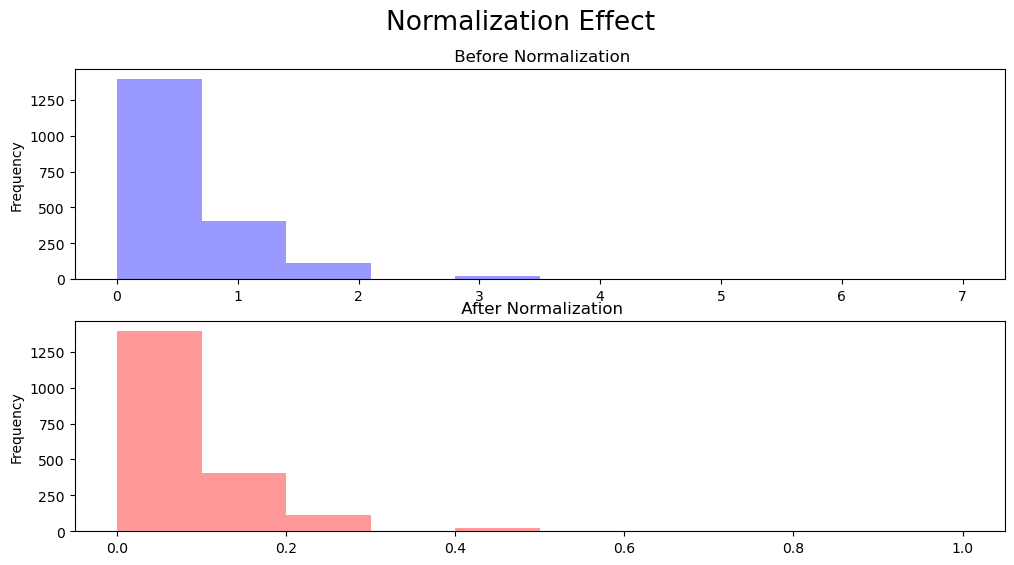

In [11]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Normalization Effect ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='blue') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'red')   

In [12]:
# Create a sliding window of 28 days and one day label 
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [13]:
# Transform our normalized training data into a sequence 
# format suitable for time series forecasting
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1912, 28, 1)
(1912, 1)


In [14]:
# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

trainX = x[:train_size]
trainY = y[:train_size]
testX = x[train_size:]
testY = y[train_size:]

print("Train data shape:", trainX.shape)
print("Train labels shape:", trainY.shape)
print("Test data shape:", testX.shape)
print("Test labels shape:", testY.shape)

Train data shape: (1529, 28, 1)
Train labels shape: (1529, 1)
Test data shape: (383, 28, 1)
Test labels shape: (383, 1)


In [15]:
# Model Configuration
hidden_size = 256  
dropout_rate = 0.2
num_classes = 1  
input_size = 1  
num_layers = 2  # Two LSTM layers
seq_length = 28  


model = Sequential()


# First LSTM layer
model.add(LSTM(hidden_size, input_shape=(seq_length, input_size), return_sequences=True, dropout=dropout_rate))

# Second LSTM layer
model.add(LSTM(hidden_size, dropout=dropout_rate))

# Adding a Dense layer before the final output for more complexity
model.add(Dense(64, activation='relu'))  
model.add(Dropout(dropout_rate))  # Dropout for the dense layer

# Final output layer
model.add(Dense(num_classes))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 806017 (3.07 MB)
Trainable params: 806017 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, min_lr=1e-7)

# Training
history = model.fit(trainX, trainY, epochs=300, batch_size=64, validation_data=(testX, testY), callbacks=[early_stopping, reduce_lr])

Epoch 1/300

24/24 [==============================] - 7s 153ms/step - loss: 0.0107 - val_loss: 0.0074 - lr: 0.0010
Epoch 2/300
24/24 [==============================] - 3s 116ms/step - loss: 0.0104 - val_loss: 0.0064 - lr: 0.0010
Epoch 3/300
24/24 [==============================] - 3s 120ms/step - loss: 0.0105 - val_loss: 0.0062 - lr: 0.0010
Epoch 4/300
24/24 [==============================] - 3s 119ms/step - loss: 0.0103 - val_loss: 0.0068 - lr: 0.0010
Epoch 5/300
24/24 [==============================] - 3s 113ms/step - loss: 0.0105 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/300
24/24 [==============================] - 3s 113ms/step - loss: 0.0105 - val_loss: 0.0063 - lr: 0.0010
Epoch 7/300
24/24 [==============================] - 3s 111ms/step - loss: 0.0103 - val_loss: 0.0062 - lr: 0.0010
Epoch 8/300
24/24 [==============================] - 3s 119ms/step - loss: 0.0105 - val_loss: 0.0062 - lr: 0.0010
Epoch 9/300
24/24 [==============================] - 3s 118ms/step - loss: 0.0103 - val

In [17]:
# Making predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Inverse Normalize
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Create DataFrames for plotting
df_train_predict = pd.DataFrame(train_predict, index=dates_list[:len(train_predict)])
df_test_predict = pd.DataFrame(test_predict, index=dates_list[-len(test_predict):])

12/12 [==============================] - 0s 23ms/step


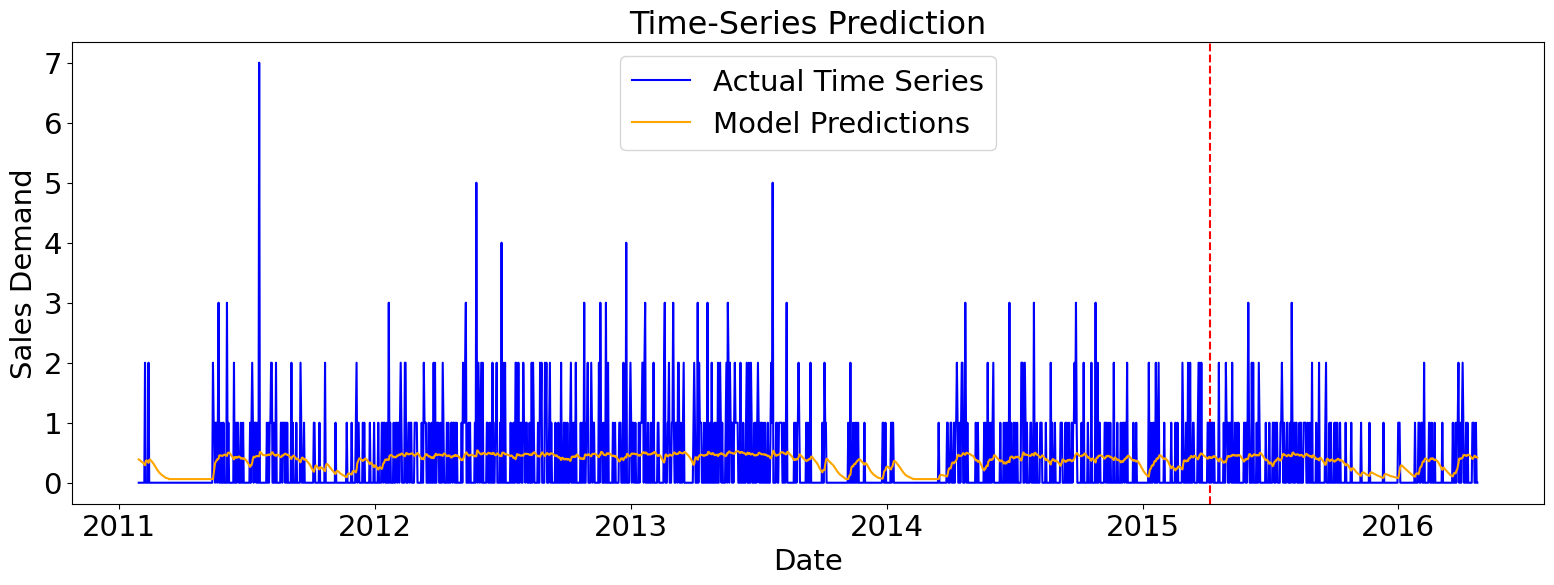

In [18]:
import matplotlib.pyplot as plt

# Assuming 'scaler' is your MinMaxScaler instance and 'y' contains your target values
# Inverse Normalize the target values for plotting
y_plot = scaler.inverse_transform(y.reshape(-1, 1))

# Creating DataFrame for actual values with dates
# Adjust the index slicing based on your dataset's date range
df_labels = pd.DataFrame(y_plot, index=dates_list[:len(y_plot)])

# Combine train and test predictions for complete view
combined_predictions = np.concatenate((train_predict, test_predict), axis=0)
df_predict = pd.DataFrame(combined_predictions, index=dates_list[:len(combined_predictions)])

# Plotting the results
plt.figure(figsize=(19, 6))
plt.axvline(x=dates_list[train_size], c='r', linestyle='--')  # Train-test split line
plt.plot(df_labels, label='Actual Time Series', color='blue')
plt.plot(df_predict, label='Model Predictions', color='orange')
plt.legend(fontsize=21)
plt.title('Time-Series Prediction', fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.show()

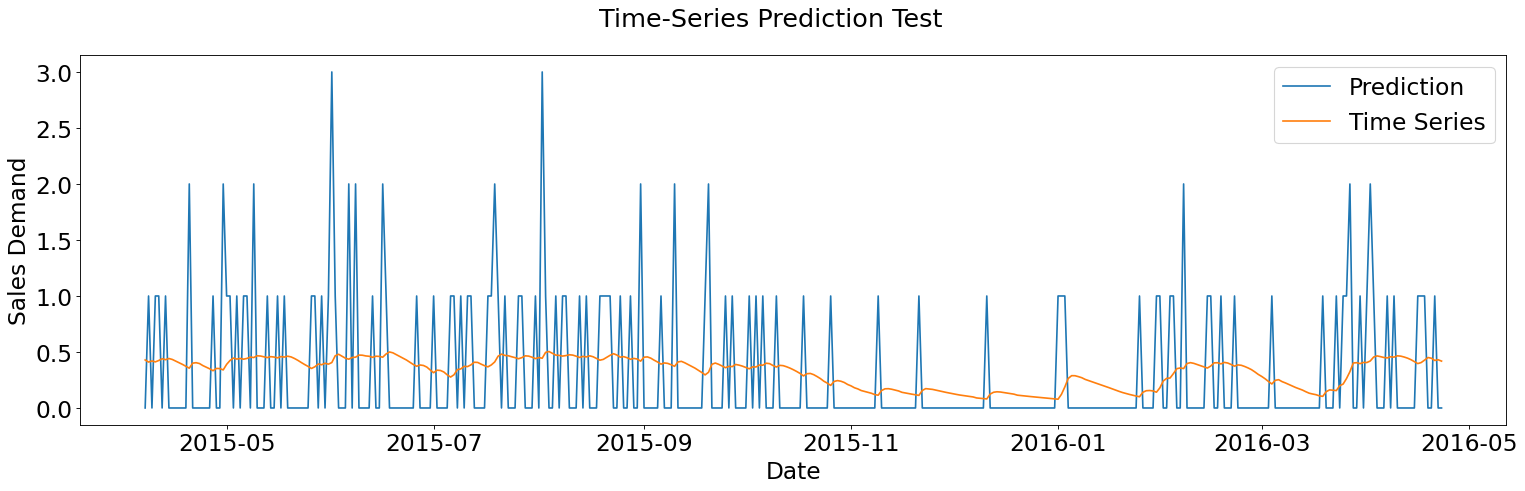

In [19]:
import matplotlib.pyplot as plt

# Ensure that 'figure' is used as intended from matplotlib
fig = plt.figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-len(testX):][0])  # Adjusted for Keras
plt.plot(df_predict.iloc[-len(testX):][0])  # Adjusted for Keras
plt.legend(['Prediction', 'Time Series'], fontsize=21)
plt.suptitle('Time-Series Prediction Test', fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.show()

In [20]:
# Calculate the length of the test set
test_set_length = len(testX)

# Extract the actual values for the test set
actual_test_values = y_plot[-test_set_length:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_test_values, test_predict))
print("Test RMSE:", rmse)

Test RMSE: 0.5481020159204935
